# Conformal Object Detection: first steps

This tutorial should get you started doing **Conformal Object Detection (COD)** with the [`cods`](https://github.com/leoandeol/cods) library.

For more information on the methods implemented in CODS, see the papers: 
- [Andéol et al. 2023: Confident Object Detection via Conformal Prediction and Conformal Risk Control](https://proceedings.mlr.press/v204/andeol23a.html)
- [Angelopoulos et al. 2022: Conformal Risk Control](https://arxiv.org/abs/2208.02814)
- [Li et al. 2022: Towards PAC Multi-Object Detection and Tracking](https://arxiv.org/abs/2204.07482)
- [Bates et al. 2021: Risk Controlling Prediction Sets](https://dl.acm.org/doi/abs/10.1145/3478535)


### Get started
1. Download the MS-COCO dataset: 
    - https://cocodataset.org/
2. Download DETR: automatically via Pytorch hub: https://pytorch.org/hub/
    - source: https://github.com/facebookresearch/detr

### Contents
What we will be doing:
1. Setup inference [⤵](#Setup-inferences)
    - load predictor (DETR) pretrained on COCO
    - Split the validation into: calibration & validation dataset
2. Run inferences on these datasets [⤵](#Setup-inferences)
    - Save predictions to disk: faster than re-predict for every test
3. Test Conformal Prediction !

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from cods.od.data import MSCOCODataset
from cods.od.models import DETRModel
import logging
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "0"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

## 2. Setup inferences [🔝](#conformal-object-detection-first-steps)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [4]:
calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = True  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.random_split(
        calibration_ratio, shuffled=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.random_split(calibration_ratio, shuffled=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
detr = DETRModel(model_name="detr_resnet50", pretrained=True)

print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


Run inferences:
- the first time, run inferences and save them disk
- if predictions are saved on disk, load them

In [5]:
preds_cal = detr.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,
)
preds_val = detr.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,
)

Loading predictions from ./saved_predictions/detr_resnet50/mscoco/cal/predictions_object_detection.pkl
Predictions already exist, loading them...
Loading predictions from ./saved_predictions/detr_resnet50/mscoco/test/predictions_object_detection.pkl
Predictions already exist, loading them...


# New Tests

In [6]:
from cods.od.cp import ODConformalizer

conf = ODConformalizer(
    backend="auto",
    guarantee_level="object",
    matching="assymetric_hausdorff",
    multiple_testing_correction=None,
    confidence_method="nb_boxes",
    localization_method="boxwise",
    localization_prediction_set="additive",
    classification_method="lac",
    optimizer="binary_search",
)

/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[WARNING:cp.py:cp:1214 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[INFO:cp.py:cp:181 - __init__ ] Defaulting to CRC backend
[INFO:cp.py:cp:898 - __init__ ] Defaulting to CRC backend


In [8]:
# TODO(leo): we can replace this by anything, doesn't even need a guarantee (confidence)
conf.calibrate(
    preds_cal,
    alpha_confidence=0.01,
    alpha_localization=0.05,
    alpha_classification=0.05,
)

[INFO:cp.py:cp:1427 - calibrate ] Calibrating Confidence Conformalizer
[0.00, 1.00] -> [0.5]. Corrected Risk = 0.00:   8%|▊         | 1/13 [00:08<01:43,  8.60s/it]

#ABOVE : TAKE INTO ACCOUNT THE MATCHING FOR THE NUMBER OF PREDICTIONS IN CLASSIFICATION:
WHY IS THE LOSS SO HIGH, THE MATCHING IS NOT UNIQUE, THERE SHOUL DALWAYS OR AKLMOST BE ONE!
Replace the objectnessloss by a threshold rahter than 100%

In [ ]:
conf_boxes = [
    pred_boxes[conf >= preds_cal.confidence_threshold]
    for conf, pred_boxes in zip(preds_cal.confidence, preds_cal.pred_boxes)
]

(array([ 2.,  0., 58.,  0., 79.,  0., 61.,  0., 39.,  0., 20.,  0., 24.,
         0., 27.,  0., 17.,  0.,  6.,  0., 13.,  0., 10.,  0.,  0.,  4.,
         0., 10.,  0.,  6.,  0.,  3.,  0.,  5.,  0.,  4.,  0.,  0.,  0.,
         5.,  0.,  1.,  0.,  3.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([ 0.  ,  0.48,  0.96,  1.44,  1.92,  2.4 ,  2.88,  3.36,  3.84,
         4.32,  4.8 ,  5.28,  5.76,  6.24,  6.72,  7.2 ,  7.68,  8.16,
         8.64,  9.12,  9.6 , 10.08, 10.56, 11.04, 11.52, 12.  , 12.48,
        12.96, 13.44, 13.92, 14.4 , 14.88, 15.36, 15.84, 16.32, 16.8 ,
        17.28, 17.76, 18.24, 18.72, 19.2 , 19.68, 20.16, 20.64, 21.12,
        21.6 , 22.08, 22.56, 23.04, 23.52, 24.  ]),
 <BarContainer object of 50 artists>)

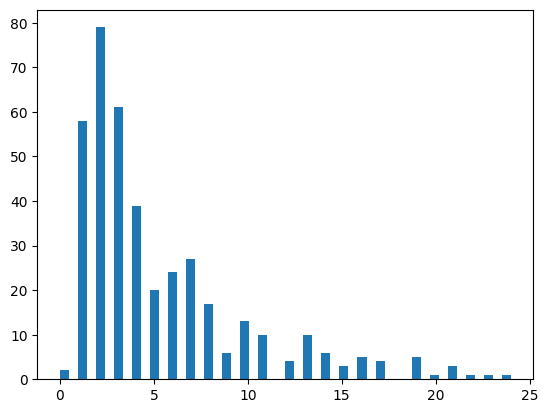

In [ ]:
import matplotlib.pyplot as plt

lengths = [len(boxes) for boxes in conf_boxes]
plt.hist(lengths, bins=50)

In [ ]:
from cods.od.utils import match_predictions_to_true_boxes

match_predictions_to_true_boxes(preds_cal)

[[[2], [2], [2], [2], [2], [1], [0]],
 [[0]],
 [[2],
  [1],
  [3],
  [3],
  [4],
  [4],
  [3],
  [6],
  [6],
  [1],
  [5],
  [4],
  [3],
  [3],
  [0],
  [0],
  [3],
  [4],
  [5],
  [0]],
 [[4], [0], [4], [2], [2]],
 [[0],
  [2],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [1],
  [0],
  [1],
  [0]],
 [[0], [2], [2]],
 [[1], [0], [0], [0], [2], [1], [1], [0]],
 [[0], [1]],
 [[3], [1], [1], [2], [1], [0], [3]],
 [[0], [0], [3], [2]],
 [[1], [0]],
 [[0]],
 [[1], [0], [3], [2], [2]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [2], [1]],
 [[0], [0]],
 [[3], [2], [0], [0]],
 [[0]],
 [[0], [1], [0], [2], [1], [1], [2], [0]],
 [[0],
  [0],
  [0],
  [2],
  [0],
  [1],
  [4],
  [0],
  [0],
  [4],
  [0],
  [0],
  [0],
  [0],
  [4],
  [0],
  [2],
  [4],
  [0],
  [4],
  [4],
  [0]],
 [[4], [3], [2], [0], [2], [2], [3], [4], [3], [2], [1]],
 [[0], [1], [2]],
 [[1], [2], [0]],
 [[1], [0], [5], [3], [2], [4], [16], [19], [6], [19], [13], [7]],
 [[5], [0], [0], [1

In [ ]:
conformal_preds = conf.conformalize(preds_val)

[INFO:cp.py:cp:1538 - conformalize ] Conformalizing Predictions
[INFO:cp.py:cp:1549 - conformalize ] Using last parameters for conformalization
[INFO:cp.py:cp:1555 - conformalize ] Conformalizing Confidence
[INFO:cp.py:cp:1571 - conformalize ] Conformalizing Localization
[INFO:cp.py:cp:513 - conformalize ] Using previous λ for localization
[INFO:cp.py:cp:528 - conformalize ] Conformalizing Localization with λ
[INFO:cp.py:cp:1581 - conformalize ] Conformalizing Classification


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [ ]:
conf.evaluate(preds_val, conformal_preds)

# 3. Test Conformal Prediction

# Sebastien

In [ ]:
from cods.od.cp import ODRiskConformalizer

odc = ODRiskConformalizer(
    localization_method="pixelwise",
    # objectness_method="box_number",
    # classification_method="lac",
    # multiple_testing_correction="bonferroni",
    confidence_threshold=0.2,
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

In [ ]:
from cods.od.cp import ODRiskConformalizer

odc = ODRiskConformalizer(
    # localization_method="pixelwise",
    # objectness_method="box_number",
    classification_method="lac",
    # multiple_testing_correction="bonferroni",
    confidence_threshold=0.2,
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

In [ ]:
from cods.od.cp import ODRiskConformalizer

odc = ODRiskConformalizer(
    localization_method="pixelwise",
    # objectness_method="box_number",
    confidence_threshold=0.2,
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

In [ ]:
from cods.od.visualization import plot_preds

plot_preds(preds_val, 1, conf_boxes, conf_cls)

# General

In [ ]:
from cods.od.cp import ODConformalizer

odc = ODConformalizer(
    localization_method="min-hausdorff-additive",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)
cal_output = odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

In [ ]:
from cods.od.cp import ODRiskConformalizer

odc = ODRiskConformalizer(
    localization_method="pixelwise",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

In [ ]:
from cods.od.tr import ODToleranceRegion

odc = ODToleranceRegion(
    localization_loss="pixelwise",
    confidence_loss="box_number",
    classification_loss="lac",
    multiple_testing_correction="bonferroni",
    inequality="bernstein",
)
odc.calibrate(preds_cal, alpha=0.2, delta=0.1, bounds=[0, 1000])
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

In [ ]:
from cods.od.visualization import plot_preds

plot_preds(preds_val, 10, conf_boxes=conf_boxes, conf_cls=conf_cls)

In [ ]:
from cods.od.metrics import unroll_metrics

unroll_metrics(od_preds=preds_val, conf_boxes=conf_boxes, conf_cls=conf_cls)